# Use google drive


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [160]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Solamente para usuarios de Jupyter Themes
# from jupyterthemes import jtplot
# jtplot.style(grid=False)

# Import MNIST - characters written by hand

In [161]:
from get_images import get_images

# Save Path and get data

In [162]:
mnist_path = './mnist_raw/'

In [163]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

In [66]:
x_test_num.shape

(10000, 28, 28)

# Convert images in vectors float32

In [164]:
x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)/255
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)/255
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)/255
y_test = y_test_num.copy().reshape(10000, 1)

x_train.shape

(50000, 784)

# Plot some images

La imagen muestreada representa un: [6]


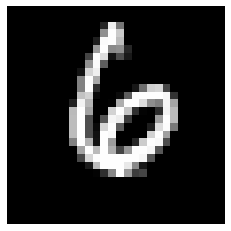

In [166]:
def plot_number(image):
  plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
  plt.axis('off')
  plt.show()

rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx]}')
plot_number(x_test_num[rnd_idx])

# Create MiniBatch

In [167]:
def create_minibatches(mb_size, x, y, shuffle = True):
  assert x.shape[0] == y.shape[0], 'error en cantidad de muestras'
  total_data = x.shape[0]
  if shuffle:
    idxs = np.arange(total_data)
    np.random.shuffle(idxs)
    x = x[idxs]
    y = y[idxs]

  return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range (0, total_data, mb_size))

# Init Parameters

In [169]:
def init_parameters(input_size, neurons):
  '''
  input size -> elementos de entrada, 784
  neurons -> list [] con cantidad de neuronas en cada capa

  mejores técnicas para redes más grandes
  '''

  W1 = np.random.randn(neurons[0], input_size) * 0.001
  b1 = np.zeros((neurons[0], 1))

  W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
  b2 = np.zeros((neurons[1], 1))

  return {'W1': W1, 'b1':b1,'W2':W2, 'b2': b2}


In [171]:
parameters = init_parameters(28*28, [200, 10])
print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['b1'].shape)
print(parameters['b2'].shape)

(200, 784)
(10, 200)
(200, 1)
(10, 1)


# Relu and Score Functions

In [184]:
def relu(x):
  return np.maximum(0, x)

In [185]:
def scores(x, parameters, activation_fcn):
  z1 = parameters['W1'] @ x + parameters['b1']
  a1 = activation_fcn(z1) # devuelve fcn de activación
  z2 = parameters['W2'] @ a1 + parameters['b2']

  return z2, z1, a1

In [186]:
scores, z1, a1 = scores(x_train[:64].T, parameters, relu)

In [174]:
x_train[:64].shape

(64, 784)

# Softmax Function

In [187]:
def softmax(x):
  exp_scores = np.exp(x)
  sum_exp_scores = np.sum(exp_scores, axis=0)
  probs = exp_scores/sum_exp_scores
  return probs


# Loss Function - Crossentropy

In [188]:
def x_entropy(scores, y, batch_size=64):
  probs = softmax(scores)
  y_hat = probs[y.squeeze(), np.arange(batch_size)]
  cost = np.sum(-np.log(y_hat)) / batch_size

  return probs, cost


In [189]:
y_hat, cost = x_entropy(scores, y_train[:64])

In [190]:
y_hat.shape

(10, 64)

# Backward Function

In [179]:
def backward(probs, x, y, z1, a1, parameters, batch_size=64):
  grads = {}
  probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
  dz2 = probs.copy()

  dW2 = dz2 @ a1.T / batch_size
  db2 = np.sum(dz2, axis = 1, keepdims = True) / batch_size
  da1 = parameters ['W2'].T @ dz2

  dz1 = da1.copy()
  dz1[z1 <= 0] = 0

  dW1 = dz1 @ x
  db1 = np.sum(dz1, axis=1, keepdims=True)

  assert parameters['W1'].shape == dW1.shape, 'W1 no es igual forma'
  assert parameters['W2'].shape == dW2.shape, 'W2 no es igual forma'
  assert parameters['b1'].shape == db1.shape, 'b1 no es igual forma'
  assert parameters['b2'].shape == db2.shape, 'b2 no es igual forma'

  grads = {'w1': dW1, 'b1':db1,'W2':dW2, 'b2': db2}

  return grads


In [180]:
grads = backward(y_hat, x_train[:64], y_train[:64], z1, a1, parameters)

# Accuracy Function

In [181]:
def accuracy(x_data, y_data, mb_size=64):
  correct=0
  total=0
  for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
    scores2, z1, a1 = scores(x.T, parameters, relu)
    y_hat, cost = x_entropy(scores2, y, batch_size=len(x))

    correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
    total += y_hat.shape[1]
  return correct/total

# Train Function

In [182]:
def train (epochs, parameters, mb_size=64, learning_rate = 1e-3):
  for epoch in range(epochs):
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
      scores2, z1, a1 = scores(x.T, parameters=parameters, activation_fcn=relu)
      y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
      grads = backward(y_hat, x, y, z1, a1, parameters, batch_size=len(x))

      parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
      parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
      parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
      parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']

    print(f'costo es: {cost}, y accuracy: {accuracy(x_val,y_val, mb_size)}')
  return parameters

In [183]:
mb_size = 512
learning_rate = 1e-2
epochs = 1
parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)

costo es: 0.5051899036913492, y accuracy: 0.8649


# Datos de prueba

In [158]:
accuracy(x_train, y_train, mb_size)

0.98656

In [159]:
accuracy(x_test, y_test, mb_size)

0.9755

# Predicciones

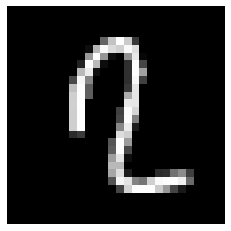

el valor predicho es: 8


In [155]:
def predict(x):
  scores2, _, _ = scores(x, parameters, relu)
  return np.argmax(scores2)

x_test[0].reshape(-1, 1).shape

idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}')